## Product recommendation 

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

### Process the data

In [2]:
product_df=pd.read_csv("C:/Users/salma/OneDrive/Documents/pfa/datasheet.csv/datasheet.csv")
print("Dataset Head:")
print(product_df.head())
print("\nMissing Values:")
print(product_df.isnull().sum())
print("\nDuplicates:")
print(product_df.duplicated().sum())


Dataset Head:
                 brand                                      name  \
0         The Ordinary          Glycolic Acid 7% Toning Solution   
1       La Roche-Posay  Toleriane Hydrating Gentle Face Cleanser   
2         The Ordinary                Niacinamide 10% + Zinc 1%    
3  Youth To The People            Superfood Antioxidant Cleanser   
4                COSRX          Low pH Good Morning Gel Cleanser   

               type        country  \
0             Toner         Canada   
1     Face Cleanser         France   
2  Facial Treatment         Canada   
3     Face Cleanser  United States   
4     Face Cleanser    South Korea   

                                         ingridients  \
0  Water,Glycolic Acid,Rosa Damascena Flower Wate...   
1  Water,Glycerin,Pentaerythrityl Tetraethylhexan...   
2  Water,Niacinamide,Pentylene Glycol,Zinc PCA,Di...   
3  Water,Cocamidopropyl Hydroxysultaine,Sodium Co...   
4  Water,Cocamidopropyl Betaine,Sodium Lauroyl Me...   

           

In [3]:
def preprocess_data(product_df):
    initial_rows=len(product_df)
    product_df= product_df.drop_duplicates()
    print(f"Dropped {initial_rows-len(product_df)} duplicates")
    
    initial_rows=len(product_df)
    product_df= product_df.dropna(subset=['afterUse'])
    print(f"Dropped {initial_rows-len(product_df)} rows with missing afterUse")
        
    initial_rows=len(product_df)
    product_df= product_df.dropna(subset=['type'])
    print(f"Dropped {initial_rows-len(product_df)} duplicates")
    
    product_df=product_df.drop('country',axis=1)
    print(product_df.isnull().sum())
    
    product_df['afterUse'] = product_df['afterUse'].str.lower().str.strip()
    product_df['ingridients'] = product_df['ingridients'].str.lower().str.strip()
    
    product_df['afterUse_list'] = product_df['afterUse'].apply(lambda x: [item.strip() for item in x.split(',')])
    product_df['afterUse_joined'] = product_df['afterUse_list'].apply(lambda x: ' '.join(x)) 
    
    product_df['ingredients_list'] = product_df['ingridients'].apply(lambda x: [item.strip() for item in x.split(',')])
    product_df['ingredients_joined'] = product_df['ingredients_list'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

    print("\nPreprocessed Data Head:")
    print(product_df[['brand', 'name', 'afterUse_joined', 'ingredients_joined']].head())
    print("\nData Types of Joined Columns:")
    print(f"afterUse_joined: {product_df['afterUse_joined'].dtype}")
    print(f"ingredients_joined: {product_df['ingredients_joined'].dtype}")
    return product_df

In [4]:
df=preprocess_data(product_df)

Dropped 10 duplicates
Dropped 1523 rows with missing afterUse
Dropped 14 duplicates
brand          0
name           0
type           0
ingridients    0
afterUse       0
dtype: int64

Preprocessed Data Head:
                 brand                                      name  \
0         The Ordinary          Glycolic Acid 7% Toning Solution   
1       La Roche-Posay  Toleriane Hydrating Gentle Face Cleanser   
2         The Ordinary                Niacinamide 10% + Zinc 1%    
3  Youth To The People            Superfood Antioxidant Cleanser   
4                COSRX          Low pH Good Morning Gel Cleanser   

                                     afterUse_joined  \
0  good for oily skin skin texture reduces large ...   
1  good for oily skin redness reducing reduces ir...   
2  good for oily skin redness reducing acne fight...   
3  redness reducing reduces irritation skin textu...   
4  good for oily skin reduces irritation reduces ...   

                                  ingredients_j

In [5]:
def build_feature_matrix(df):
    required_columns = ['name', 'type', 'afterUse_joined', 'ingredients_joined']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}. Ensure preprocess_data is called first.")

    if not all(df['afterUse_joined'].apply(lambda x: isinstance(x, str))):
        raise ValueError("Column 'afterUse_joined' contains non-string values. Ensure preprocess_data creates strings.")
    if not all(df['ingredients_joined'].apply(lambda x: isinstance(x, str))):
        raise ValueError("Column 'ingredients_joined' contains non-string values. Ensure preprocess_data creates strings.")

    preprocessor = ColumnTransformer(
        transformers=[
            ('name_cat', OneHotEncoder(handle_unknown='ignore'), ['name']),
            ('type_cat', OneHotEncoder(handle_unknown='ignore'), ['type']),
            ('afterUse_tfidf', TfidfVectorizer(), 'afterUse_joined'),
            ('ingredients_tfidf', TfidfVectorizer(), 'ingredients_joined')
        ]
    )

    feature_matrix = preprocessor.fit_transform(df)
    return feature_matrix, preprocessor

In [6]:
feature_matrix, preprocessor=build_feature_matrix(df)

def visualize_skin_type_condition_heatmap(preprocessor):
    sk_type = ['dry', 'normal', 'oily']
    sk_cond = ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']

    skin_type_condition_combinations = [f"{skin_type}_{condition}" for skin_type in sk_type for condition in sk_cond]

    skin_type_to_benefits = {
        'oily': 'good for oily skin reduces large pores',
        'dry': 'hydrating',
        'normal': 'skin texture anti-aging brightening scar healing'
    }
    condition_to_benefits = {
        'Acne': 'acne fighting reduces large pores',
        'Rosacea': 'redness reducing reduces irritation',
        'Eczema': 'eczema',
        'Carcinoma': 'dark spots',
        'Keratosis': 'dark spots',
        'Milia': 'skin texture'
    }

    user_profiles = []
    for skin_type in sk_type:
        for condition in sk_cond:
            user_benefits = []
            if skin_type.lower() in skin_type_to_benefits:
                user_benefits.append(skin_type_to_benefits[skin_type.lower()])
            if condition.lower() in condition_to_benefits:
                user_benefits.append(condition_to_benefits[condition.lower()])
            
            user_profile = {
                'name': 'Unknown',
                'type': 'Unknown',
                'afterUse_joined': ' '.join(user_benefits),
                'ingredients_joined': ''
            }
            user_profiles.append(user_profile)

    user_profiles_df = pd.DataFrame(user_profiles)
    user_features = preprocessor.transform(user_profiles_df)

    name_features = preprocessor.named_transformers_['name_cat'].get_feature_names_out(['name'])
    type_features = preprocessor.named_transformers_['type_cat'].get_feature_names_out(['type'])
    afterUse_features = preprocessor.named_transformers_['afterUse_tfidf'].get_feature_names_out()

    name_feature_count = len(name_features)
    type_feature_count = len(type_features)
    afterUse_start_idx = name_feature_count + type_feature_count
    afterUse_end_idx = afterUse_start_idx + len(afterUse_features)

    subset_cols = 20
    user_features_subset = user_features[:, afterUse_start_idx:afterUse_start_idx + subset_cols].toarray()

    feature_names = afterUse_features[:subset_cols]

    plt.figure(figsize=(12, 8))
    sns.heatmap(user_features_subset, cmap='viridis', cbar=True, xticklabels=feature_names, yticklabels=skin_type_condition_combinations)
    plt.title('Heatmap of Skin Type-Condition vs. afterUse TF-IDF Features')
    plt.xlabel('TF-IDF Feature (afterUse)')
    plt.ylabel('Skin Type-Condition')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()


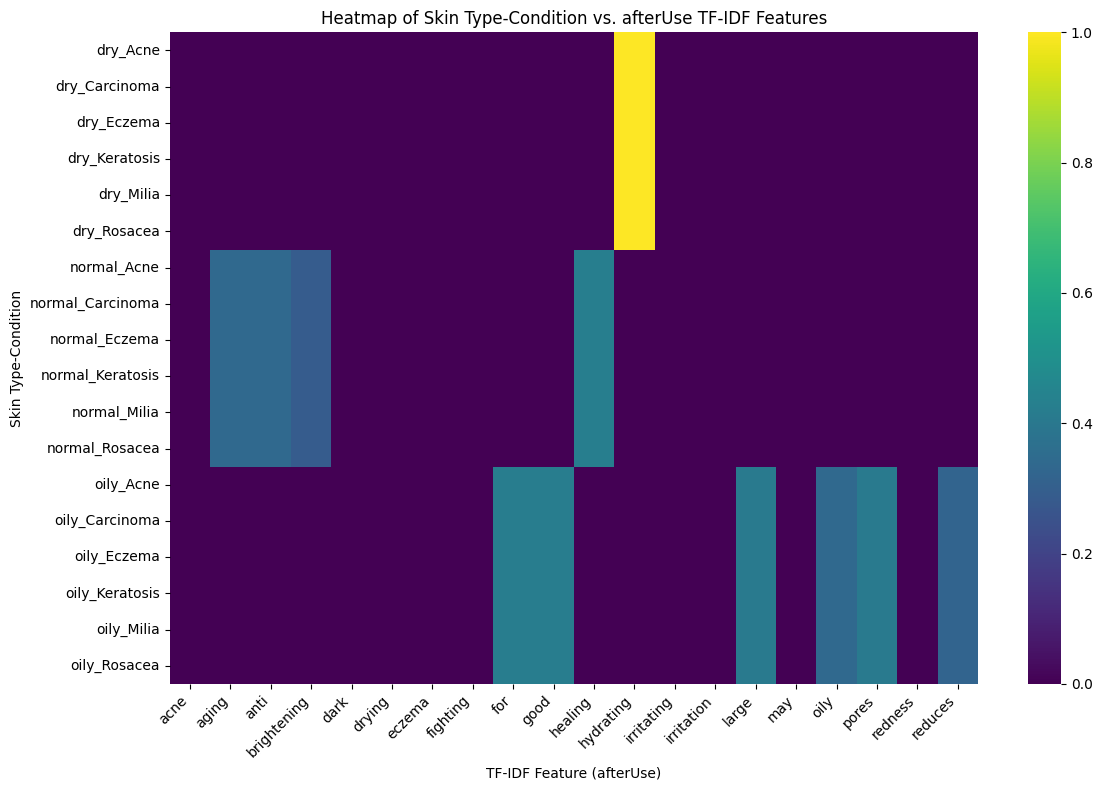

In [8]:
visualize_skin_type_condition_heatmap(preprocessor)

In [33]:
def recommend_products(df, feature_matrix, preprocessor, skin_type=None, condition=None):
    required_columns = ['name', 'type', 'afterUse_joined', 'ingredients_joined']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}. Ensure preprocess_data is called first.")

    user_profile = {
        'name': '',  
        'type': '',
        'afterUse_joined': '',
        'ingredients_joined': ''  
    }

    skin_type_to_benefits = {
        'oily': 'good for oily skin reduces large pores',
        'dry': 'hydrating',
        'normal': 'skin texture anti-aging brightening scar healing'
    }
    condition_to_benefits = {
        'Acne': 'acne fighting reduces large pores',
        'Rosacea': 'redness reducing reduces irritation',
        'Eczema': 'eczema',
        'Carcinoma': 'dark spots',
        'Keratosis': 'dark spots',
        'Milia': 'skin texture'
    }

    user_benefits = []
    if condition and condition.lower() in condition_to_benefits:
        user_benefits.append(condition_to_benefits[condition.lower()])
    if skin_type and skin_type.lower() in skin_type_to_benefits:
        user_benefits.append(skin_type_to_benefits[skin_type.lower()])
    
    if not user_benefits:
        user_benefits.append('')  
    user_profile['afterUse_joined'] = ' '.join(user_benefits)

    user_features = preprocessor.transform(pd.DataFrame([user_profile]))

    afterUse_start_idx = (len(preprocessor.named_transformers_['name_cat'].get_feature_names_out(['name'])) +
                         len(preprocessor.named_transformers_['type_cat'].get_feature_names_out(['type'])))
    afterUse_features = preprocessor.named_transformers_['afterUse_tfidf'].get_feature_names_out()
    user_features_array = user_features.toarray()
    print(f"\nUser Profile Features for {skin_type}_{condition}:")
    for idx, value in enumerate(user_features_array[0][afterUse_start_idx:]):
        if value > 0:
            print(f"{afterUse_features[idx]}: {value}")

    similarities = cosine_similarity(user_features, feature_matrix)[0]
    
    print("\nSimilarity scores summary:")
    print("Max similarity:", similarities.max())
    print("Scores > 0.2:", (similarities > 0.2).sum())
    
    df['similarity_score'] = similarities

    matches = df

    top_matches = matches[matches['similarity_score'] > 0.2].sort_values(by='similarity_score', ascending=False).head(4)
    print("\nNumber of top matches:", len(top_matches))
    
    if top_matches.empty:
        print("Top products (without threshold):")
        print(matches.sort_values(by='similarity_score', ascending=False)[['brand', 'name', 'type', 'similarity_score']].head())
        return "No matching products found."

    recommendations = top_matches[['brand', 'name', 'type', 'afterUse']].to_dict(orient='records')
    return recommendations

In [34]:
import os
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(feature_matrix, 'feature_matrix.pkl')
df.to_pickle('product_df.pkl')

# Step 2: Verify files exist
print("Files in current directory:", os.listdir('.'))

# Step 3: Load the model components
try:
    preprocessor = joblib.load('preprocessor.pkl')
    feature_matrix = joblib.load('feature_matrix.pkl')
    df = pd.read_pickle('product_df.pkl')
    print("Files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the files exist in the directory: {os.getcwd()}")

Files in current directory: ['.ipynb_checkpoints', '.vscode', 'dataset', 'datasheet.csv', 'feature_matrix.pkl', 'milia.jpg', 'OIP (1).jpg', 'OIP (2).jpg', 'OIP (3).jpg', 'OIP.jpg', 'preprocessor.pkl', 'product_df.pkl', 'R (1).jpg', 'R (2).jpg', 'R.jpg', 'skin care products .ipynb', 'skin type detection using efficientnet_b0.ipynb', 'skin type detection using resnet50.ipynb', 'skin_cond_checkpoint.pth', 'skin_cond_full_model.pth', 'skin_cond_weights.pth', 'skin_type_checkpoint.pth', 'skin_type_full_model.pth', 'skin_type_weights.pth', 'splitting the s_cond dataset.ipynb']
Files loaded successfully!


In [35]:
recommendations = recommend_products(
    df=df,
    feature_matrix=feature_matrix,
    preprocessor=preprocessor,
    skin_type='oily',
    condition='Acne'
)
print(recommendations)


User Profile Features for oily_Acne:
for: 0.42014120433548163
good: 0.42014120433548163
large: 0.40807178847536096
oily: 0.3376958500016905
pores: 0.40807178847536096
reduces: 0.3191354612955035
skin: 0.3131000446749324

Similarity scores summary:
Max similarity: 0.4515699913129791
Scores > 0.2: 7392

Number of top matches: 4
[{'brand': 'COSRX', 'name': 'One Step Original Clear Pad', 'type': 'Toner', 'afterUse': 'good for oily skin,reduces irritation,reduces large pores'}, {'brand': 'COSRX', 'name': 'AC Collection Calming Liquid Mild', 'type': 'Toner', 'afterUse': 'good for oily skin,reduces irritation,reduces large pores'}, {'brand': 'PURITO', 'name': 'BHA Dead Skin Moisture Gel', 'type': 'General Moisturizer', 'afterUse': 'good for oily skin,reduces irritation,reduces large pores'}, {'brand': 'Celimax', 'name': 'Jiwoogae Heartleaf BHA Peeling Pad', 'type': 'Exfoliator', 'afterUse': 'good for oily skin,reduces irritation,reduces large pores'}]
